# <font  color = "#0093AF"> Pseudo-Contact Shift

In the previous tutorial (Contact Shift), we saw that while polarization on a fast-relaxing electron leaves a residual part of the hyperfine coupling acting on the nucleus. We do not get a splitting, but rather a frequency shift, resulting from the average of the hyperfine doublet, where one side of the double is larger than the other, resulting from polarization on the electron. However, where this splitting arises from a dipole coupling, we find that the resulting residual coupling tensor has an orientational average of zero. Then isotropic motion or magical angle spinning removes the effects of the contact shift entirely.

On the other hand, the pseudo-contact shift is not removed by isotropic motion or magic angle spinning. In case the electron has a large anisotropy on the g-tensor, tilting of the electron quantization axis away from the magnetic field prevents motion or spinning from completely averaging away the hyperfine coupling.

In [181]:
# Imports
import sys,os
sys.path.append(os.path.expanduser('~/Documents/GitHub/'))
sys.path.append(os.path.expanduser('~/Documents/GitHub.nosync/'))
import SLEEPY as sl
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

In [5]:
%matplotlib notebook

## Solution-State

There are a few critical components to bring about the pseudo-contact shift, including an electron-nuclear hyperfine coupling, tilting of the electron brought about the g-tensor, and electron relaxation towards thermal equilibrium. We show the correct setup for the pseudocontact shift first, but then remove some terms, to show why each parameter is important.

State-space reduction: 48->6


<IPython.core.display.Javascript object>


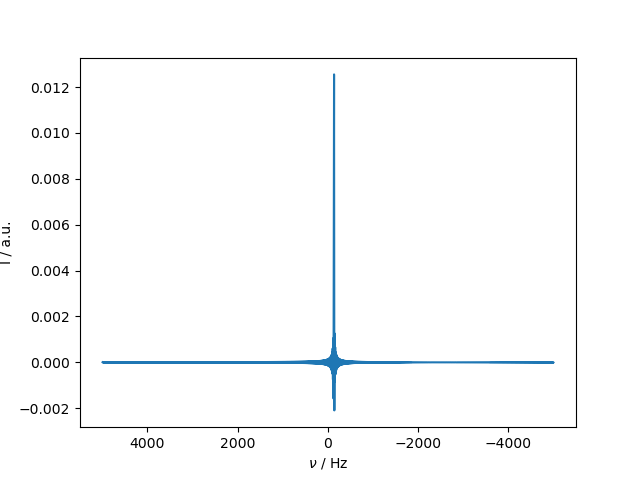

In [123]:
delta=sl.Tools.dipole_coupling(1.2,'e-','13C')    #12 Angstroms from electron
ex0=sl.ExpSys(v0H=600,Nucs=['13C','e-'],LF=[False,False],vr=0,T_K=100,pwdavg=sl.PowderAvg('alpha0beta0'))  #Electron-nuclear system
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex0.set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=[0,np.pi/3,0])

# This sets up three systems which will be in exchange in the Liouvillian
# They are oriented along the x, y, and z axes to average out the couplings
# Changing q=1 will set up a tetrahedral hop 
# Higher q values will set up a tumbling based on the rep powder averages, but are not currently recommended
ex,kex=sl.Tools.SetupTumbling(ex0,tc=1e-9,q=0) #1 ns tumbling

L=sl.Liouvillian(ex,kex=kex)
L.add_relax('T1',i=1,T1=1e-9,OS=True,Thermal=True)  #1 microsecond T1
L.add_relax('T2',i=1,T2=1e-12,OS=True) #1 ns T2, required for physical system when T1 is present

seq=L.Sequence(Dt=1e-4)

rho=sl.Rho('Thermal','13Cp')  #Generate initial state, detection operator
Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
(Upi2*rho).DetProp(seq,n=800) #Propagate the system
rho.downmix()
ax=rho.plot(FT=True,apodize=False) #Plot the results into the same axis

In [186]:
# Sweep euler angles
sl.Defaults['verbose']=False
SZ=[20,40]
beta=np.linspace(0,np.pi/2,SZ[0])
gamma=np.linspace(0,np.pi*2,SZ[1])
N=beta.size*gamma.size

beta,gamma=np.meshgrid(beta,gamma)
shift=[]
for k,(beta0,gamma0) in enumerate(zip(beta.reshape(np.prod(SZ)),gamma.reshape(np.prod(SZ)))):
    delta=sl.Tools.dipole_coupling(1.2,'e-','13C')    #12 Angstroms from electron
    ex0=sl.ExpSys(v0H=600,Nucs=['13C','e-'],LF=[False,False],vr=0,T_K=100,pwdavg=sl.PowderAvg('alpha0beta0'))  #Electron-nuclear system
    ex0.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
    ex0.set_inter('g',i=1,gxx=1,gyy=1,gzz=8,euler=[0,beta0,gamma0])

    # This sets up three systems which will be in exchange in the Liouvillian
    # They are oriented along the x, y, and z axes to average out the couplings
    # Changing q=1 will set up a tetrahedral hop 
    # Higher q values will set up a tumbling based on the rep powder averages, but are not currently recommended
    ex,kex=sl.Tools.SetupTumbling(ex0,tc=1e-9,q=0) #1 ns tumbling

    L=sl.Liouvillian(ex,kex=kex)
    L.add_relax('T1',i=1,T1=1e-9,OS=True,Thermal=True)  #1 microsecond T1
    L.add_relax('T2',i=1,T2=1e-12,OS=True) #1 ns T2, required for physical system when T1 is present

    seq=L.Sequence(Dt=1e-4)

    rho=sl.Rho('Thermal','13Cp')  #Generate initial state, detection operator
    Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
    (Upi2*rho).DetProp(seq,n=800) #Propagate the system
    rho.downmix()

    i=np.argmax(rho.FT[0])
    shift.append(rho.v_axis[i])
    if np.mod(k,100)==0:print(k)
        
shift=np.array(shift).reshape([SZ[1],SZ[0]])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750


<IPython.core.display.Javascript object>


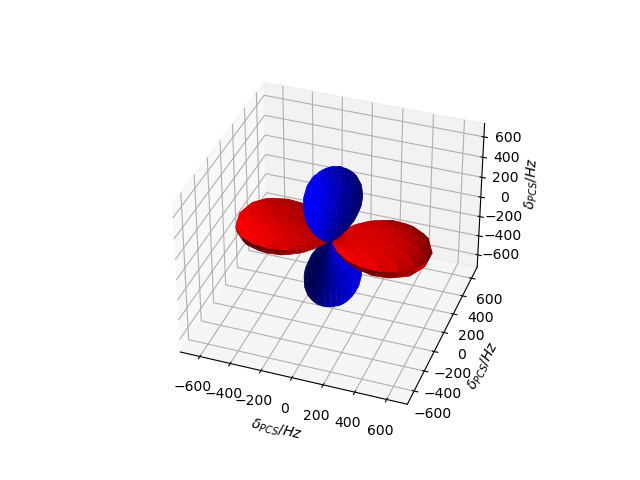

In [193]:
x=shift*np.sin(beta)*np.cos(gamma)
y=shift*np.sin(beta)*np.sin(gamma)
z=shift*np.cos(beta)

ax=plt.figure().add_subplot(1,1,1,projection='3d')
i=shift>0

x0,y0,z0=copy(x),copy(y),copy(z)
for q in [x0,y0,z0]:q[i]=0
ax.plot_surface(x0,y0,z0,color='red')
ax.plot_surface(x0,y0,-z0,color='red')

x0,y0,z0=copy(x),copy(y),copy(z)
for q in [x0,y0,z0]:q[~i]=0
ax.plot_surface(x0,y0,z0,color='blue')
ax.plot_surface(x0,y0,-z0,color='blue')


# ax.plot_surface(x[~i],y[~i],z[~i])
for q in ['x','y','z']:
    getattr(ax,f'set_{q}lim')([-700,700])
    getattr(ax,f'set_{q}label')(r'$\delta_{PCS} / Hz$')
    

## Solid-state 

<IPython.core.display.Javascript object>


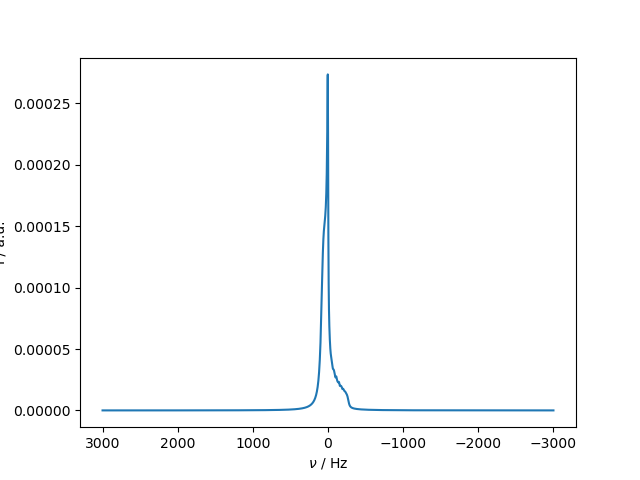

In [117]:
delta=sl.Tools.dipole_coupling(1.2,'e-','13C')    #12 Angstroms from electron
pwd=sl.PowderAvg(q=4)
ex=sl.ExpSys(v0H=600,Nucs=['13C','e-'],vr=6000,LF=[True,True],T_K=200,pwdavg=pwd,n_gamma=30)  #Electron-nuclear system
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=1,gyy=1,gzz=4)
    
L=sl.Liouvillian(ex)        #Generate a Liouvillian

L.add_relax('T1',i=1,T1=1e-7,OS=True,Thermal=True)  #1 microsecond T1
L.add_relax('T2',i=1,T2=1e-7,OS=True) #1 ns T2, required for physical system when T1 is present

seq=L.Sequence() #Generate an empty sequence

rho=sl.Rho('13Cx','13Cp')  #Generate initial state, detection operator
rho.DetProp(seq,n=8000,n_per_seq=1) #Propagate the system
rho.downmix()
ax=rho.plot(FT=True,apodize=True) #Plot the results into the same axis
# ax.set_xlim([5000,-5000])